In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import sympy

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

In [2]:
n_bar = 5
N = 8

# MSDS

In [3]:
def msds(N,arr):
    w_e = 0
    e_e = 0
    n_e = 0
    s_e = 0
    nw_e = 0
    ne_e = 0
    sw_e = 0
    se_e = 0
    for row in range(arr.shape[0] // N):
        for col in range(arr.shape[1] // N):
            f_block = arr[row * N : (row + 1) * N, col * N : (col + 1) * N]
            # w
            if col == 0:
                w_block = np.fliplr(f_block)
            else:
                w_block = arr[row * N : (row + 1) * N, (col - 1) * N : col * N]
            # e
            if col == arr.shape[1] // N - 1:
                e_block = np.fliplr(f_block)
            else:
                e_block = arr[row * N : (row + 1) * N, (col + 1) * N : (col + 2) * N]
            # n
            if row == 0:
                n_block = np.flipud(f_block)
            else:
                n_block = arr[(row - 1) * N : row * N, col * N : (col + 1) * N]
            # s
            if row == arr.shape[0] // N - 1:
                s_block = np.flipud(f_block)
            else:
                s_block = arr[(row + 1) * N : (row + 2) * N, col * N : (col + 1) * N]

            w_d1 = f_block[:, 0] - w_block[:, N-1]
            e_d1 = f_block[:, N-1] - e_block[:, 0]
            n_d1 = f_block[0, :] - n_block[N-1, :]
            s_d1 = f_block[N-1, :] - s_block[0, :]

            w_d2 = (w_block[:, N-1] - w_block[:, N-2] + f_block[:, 1] - f_block[:, 0]) / 2
            e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, N-1] - f_block[:, N-2]) / 2
            n_d2 = (n_block[N-1, :] - n_block[N-2, :] + f_block[1, :] - f_block[0, :]) / 2
            s_d2 = (s_block[1, :] - s_block[0, :] + f_block[N-1, :] - f_block[N-2, :]) / 2

            w_e += np.sum((w_d1 - w_d2) ** 2 )
            e_e += np.sum((e_d1 - e_d2) ** 2 )
            n_e += np.sum((n_d1 - n_d2) ** 2)
            s_e += np.sum((s_d1 - s_d2) ** 2)

            # nw
            if row == 0 or col == 0:
                nw_block = np.flipud(np.fliplr(f_block))
            else:
                nw_block = arr[(row - 1) * N : row * N, (col - 1) * N : col * N]
            # ne
            if row == 0 or col == arr.shape[1] // N - 1:
                ne_block = np.flipud(np.fliplr(f_block))
            else:
                ne_block = arr[(row-1) * N : row * N, (col + 1) * N : (col + 2) * N]
            # sw
            if row == arr.shape[0] // N -1 or col == 0:
                sw_block = np.flipud(np.fliplr(f_block))
            else:
                sw_block = arr[row * N : (row+1) * N, (col-1) * N : col * N]
            # se
            if  row == arr.shape[0]//N-1 or col == arr.shape[0] // N -1:
                se_block = np.flipud(np.fliplr(f_block))
            else:
                se_block = arr[(row + 1) * N : (row + 2) * N, (col+1) * N : (col + 2) * N]

            nw_g1 = f_block[0, 0] - nw_block[N-1, N-1]
            ne_g1 = f_block[0, N-1] - ne_block[N-1, 0]
            sw_g1 = f_block[N-1, 0] - sw_block[0, N-1]
            se_g1 = f_block[N-1, N-1] - se_block[0, 0]

            nw_g2 = (nw_block[N-1,N-1] - nw_block[N-2,N-2] + f_block[1,1] - f_block[0,0])/2
            ne_g2 = (ne_block[N-1,0] - ne_block[N-2,1] + f_block[1,N-2] - f_block[0,N-1])/2
            sw_g2 = (sw_block[0,N-1] - nw_block[1,N-2] + f_block[N-2,1] - f_block[N-1,0])/2
            se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[N-2,N-2] - f_block[N-1,N-1])/2

            nw_e += (nw_g1 - nw_g2) ** 2 
            ne_e += (ne_g1 - ne_g2) ** 2 
            sw_e += (sw_g1 - sw_g2) ** 2 
            se_e += (se_g1 - se_g2) ** 2 

    MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    MSDS1 = (w_e + e_e + n_e + s_e)/ ((arr.shape[0]/N)**2)
    MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    return MSDSt, MSDS1, MSDS2

In [4]:
IMG = LENNA

In [5]:
# 重み係数計算
def dm2coef(N):
    xn = np.zeros(N)
    for iell in range(N):
        xn[iell] = (2*iell+1)/(2*N)
    
    co = np.zeros((N,N))
    for i in range(N):
        for ik in range(N):
            co[ik,i] = np.cos(np.pi * ik * xn[i])
            
    P0 = np.zeros(N)
    P1 = np.zeros(N)
    for i in range(N):
        P0[i] = -1 * (1/2) * (xn[i] - 1) ** 2
        P1[i] = (1/2) * xn[i] ** 2
        
    P0matrix = np.tile(P0,(N,1))
    P1matrix = np.tile(P1,(N,1))
    
    W0 = co * P0matrix
    W1 = co * P1matrix
    
    COMAT1 = np.sum(W0, axis=1) * np.sqrt(2/N)
    COMAT2 = np.sum(W1, axis=1) * np.sqrt(2/N)
    return COMAT1, COMAT2

In [6]:
def dm3coef(N):
    xn = np.zeros(N)
    for iell in range(N):
        xn[iell] = (2*iell+1)/(2*N)
    
    co = np.zeros((N,N))
    for i in range(N):
        for ik in range(N):
            co[ik,i] = np.cos(np.pi * ik * xn[i])
            
    P0 = np.zeros(N)
    P1 = np.zeros(N)
    P2 = np.zeros(N)
    for i in range(N):
        P0[i] = (2/3) * xn[i] ** 3 - (3/2) * xn[i] ** 2 + xn[i]
        P1[i] = -(4/3) * xn[i] ** 3 + 2 * xn[i] ** 2
        P2[i] = (2/3) * xn[i] ** 3 -(1/2) * xn[i] ** 2
        
    P0matrix = np.tile(P0,(N,1))
    P1matrix = np.tile(P1,(N,1))
    P2matrix = np.tile(P2,(N,1))
    
    W0 = co * P0matrix
    W1 = co * P1matrix
    W2 = co * P2matrix
    
    COMAT1 = np.sum(W0, axis=1) * np.sqrt(2/N)
    COMAT2 = np.sum(W1, axis=1) * np.sqrt(2/N)
    COMAT3 = np.sum(W2, axis=1) * np.sqrt(2/N)
    return COMAT1, COMAT2, COMAT3

In [22]:
def dm4coef(N):
    xn = np.zeros(N)
    for iell in range(N):
        xn[iell] = (2*iell+1)/(2*N)
    
    co = np.zeros((N,N))
    for i in range(N):
        for ik in range(N):
            co[ik,i] = np.cos(np.pi * ik * xn[i])
#     print(co)
            
    P0 = np.zeros(N)
    P1 = np.zeros(N)
    P2 = np.zeros(N)
    P3 = np.zeros(N)
    for i in range(N):
        P0[i] = (-9/8) * xn[i] ** 4 + 3 * xn[i] ** 3 + (-11/4) * xn[i] ** 2 + xn[i]
        P1[i] = (27/8) * xn[i] ** 4 + (-15/2) * xn[i] ** 3 + (9/2) * xn[i] ** 2
        P2[i] = (-27/8) * xn[i] ** 4 + 6 * xn[i] ** 3 + (-9/4) * xn[i] ** 2
        P3[i] = (9/8) * xn[i] ** 4 + (-3/2) * xn[i] ** 3 + (1/2) * xn[i] ** 2
        
    P0matrix = np.tile(P0,(N,1))
#     print(P0matrix)
    P1matrix = np.tile(P1,(N,1))
    P2matrix = np.tile(P2,(N,1))
    P3matrix = np.tile(P3,(N,1))
    
    W0 = co * P0matrix
#     print(W0)
    W1 = co * P1matrix
    W2 = co * P2matrix
    W3 = co * P3matrix
    
    COMAT1 = np.sum(W0, axis=1) * np.sqrt(2/N)
    print(COMAT1)
    COMAT2 = np.sum(W1, axis=1) * np.sqrt(2/N)
    print(COMAT2)
    COMAT3 = np.sum(W2, axis=1) * np.sqrt(2/N)
    print(COMAT3)
    COMAT4 = np.sum(W3, axis=1) * np.sqrt(2/N)
    print(COMAT4)
    return COMAT1, COMAT2, COMAT3, COMAT4

In [23]:
COMAT1, COMAT2, COMAT3, COMAT4 = dm4coef(N)


[ 0.43590546 -0.03308095 -0.02931474 -0.03754339 -0.01782441 -0.01199148
 -0.00626287 -0.00307165]
[ 1.20009613e+00 -3.69564240e-01 -2.07773481e-01 -4.54753960e-03
 -1.28180367e-02 -5.64949375e-04 -2.22740699e-03 -9.72466487e-05]
[ 2.99903870e-01 -3.69564240e-01  2.07773481e-01 -4.54753960e-03
  1.28180367e-02 -5.64949375e-04  2.22740699e-03 -9.72466487e-05]
[ 0.06409454 -0.03308095  0.02931474 -0.03754339  0.01782441 -0.01199148
  0.00626287 -0.00307165]


In [9]:
def dmlct4e(IMG,N):
    
    F = np.zeros(IMG.shape)
    for row in range(IMG.shape[0] // N):
        for col in range(IMG.shape[1]):
            eight_points = IMG[N * row : N * (row + 1), col]
            c = scipy.fftpack.dct(eight_points, norm="ortho")
            F[N * row : N * (row + 1), col] = c

    # 垂直方向にDCT係数が並列に並んでいるとみなす
    F0mFL0 = np.concatenate(
        # その時の直流成分を取り出す
        # index外はミラー処理すると、1行目は0となる
        [np.zeros((1,IMG.shape[1])), F[N::N,:] - F[:-N:N,:]], 0
    )
    FR0mF0 = np.concatenate(
        [F[N::N,:] - F[:-N:N], np.zeros((1,IMG.shape[1]))], 0
    )
    F1pFL1 = np.concatenate(
        [np.zeros((1,IMG.shape[1])), F[1+N::N,:] + F[1:-N:N,:]], 0
    )
    FR1pF1 = np.concatenate(
        [F[1+N::N,:] + F[1:-N:N,:], np.zeros((1,IMG.shape[1]))], 0
    )
    F2mFL2 = np.concatenate(
        [np.zeros((1,IMG.shape[1])), F[2+N::N,:] - F[2:-N:N,:]], 0
    )
    FR2mF2 = np.concatenate(
        [F[2+N::N,:] - F[2:-N:N,:], np.zeros((1,IMG.shape[1]))], 0
    )
    F1 = F[1::N,:]
    F2 = F[2::N,:]

    U = np.zeros(IMG.shape)

    # 第1交流成分予測
    DM2COMAT1, DM2COMAT2 = dm2coef(N)
    DM2L = F0mFL0 / np.sqrt(N)
    DM2R = FR0mF0 / np.sqrt(N)
    k=2
    U[k-1::N,:] = DM2L * DM2COMAT1[k] + DM2R * DM2COMAT2[k]

    DM3COMAT1, DM3COMAT2, DM3COMAT3 = dm3coef(N)
    DM3L = (2/np.sqrt(N)) * (F0mFL0 + F1pFL1)
    DM3M = (-4/np.sqrt(N)) * F1
    DM3R = (2/np.sqrt(N)) * (FR0mF0 + FR1pF1)
    k=3
    U[k-1::N,:] = DM3L * DM3COMAT1[k] + DM3M * DM3COMAT2[k] + DM3R * DM3COMAT3[k]

    DM4COMAT1, DM4COMAT2, DM4COMAT3, DM4COMAT4 = dm4coef(N)
    DM4L = 3 * np.sqrt(2/N) * ( (1/np.sqrt(2)) * F0mFL0 + (np.sqrt(3)/2 ) * F1pFL1 + (1/2) * F2mFL2)
    DM4M1 = 3 * np.sqrt(2/N) * ( (-np.sqrt(3)/2)*F1 + (-3/2) * F2 )
    DM4M2 = 3 * np.sqrt(2/N) * ( (-np.sqrt(3)/2)*F1 + (3/2) * F2 )
    DM4R = 3 * np.sqrt(2/N) * ( (1/np.sqrt(2) ) * FR0mF0 + (np.sqrt(3)/2 ) * FR1pF1 + (1/2)*FR2mF2)

    for k in range(4,N,1):
        U[k-1::N,:] = DM4L * DM4COMAT1[k] + DM4M1 * DM4COMAT2[k] + DM4M2 * DM4COMAT3[k] + DM4R * DM4COMAT4[k]

    V = F - U
    return V

In [10]:
V = dmlct4e(IMG.img,N)
V = dmlct4e(V.T,N)

[[ 1.          1.          1.          1.          1.          1.
   1.          1.        ]
 [ 0.98078528  0.83146961  0.55557023  0.19509032 -0.19509032 -0.55557023
  -0.83146961 -0.98078528]
 [ 0.92387953  0.38268343 -0.38268343 -0.92387953 -0.92387953 -0.38268343
   0.38268343  0.92387953]
 [ 0.83146961 -0.19509032 -0.98078528 -0.55557023  0.55557023  0.98078528
   0.19509032 -0.83146961]
 [ 0.70710678 -0.70710678 -0.70710678  0.70710678  0.70710678 -0.70710678
  -0.70710678  0.70710678]
 [ 0.55557023 -0.98078528  0.19509032  0.83146961 -0.83146961 -0.19509032
   0.98078528 -0.55557023]
 [ 0.38268343 -0.92387953  0.92387953 -0.38268343 -0.38268343  0.92387953
  -0.92387953  0.38268343]
 [ 0.19509032 -0.55557023  0.83146961 -0.98078528  0.98078528 -0.83146961
   0.55557023 -0.19509032]]
[[ 1.          1.          1.          1.          1.          1.
   1.          1.        ]
 [ 0.98078528  0.83146961  0.55557023  0.19509032 -0.19509032 -0.55557023
  -0.83146961 -0.98078528]
 [ 0.

In [11]:
V = V.T

In [12]:
V

array([[ 1.28350000e+03,  5.22567783e+00,  3.43535716e+00, ...,
        -2.93060521e-02, -1.07608163e+01, -1.03705202e+00],
       [ 9.05384010e+00, -9.12347094e-01,  8.63147558e-01, ...,
        -4.03042670e+00, -4.98082389e+00, -5.50663905e+00],
       [-5.83866157e+00, -3.84503529e-01, -1.79849011e+00, ...,
         1.49907936e+00,  1.56729265e+00,  3.71207863e+00],
       ...,
       [ 3.33262632e+00,  1.14249469e+00,  3.55320031e+00, ...,
         5.49227127e-01, -7.86949495e-01, -2.21082484e+00],
       [-5.04600995e-01, -2.22391375e+00, -6.84110037e-01, ...,
        -4.35660473e+00,  2.17297211e+00,  2.32292864e+00],
       [ 1.14765763e+00, -1.40761585e+00, -3.01550749e+00, ...,
        -4.82292368e+00,  1.34679998e+00,  2.10713405e+00]])

In [13]:
pd.DataFrame(V).to_csv("DMLCT_lenna_ashi_coef.csv",header=False,index=False)

In [14]:
def idmlct4e(V,N):
    F = np.zeros(V.shape)
    U = np.zeros(V.shape)
    
    DM2COMAT1, DM2COMAT2 = dm2coef(N)

    F0mFL0 = np.concatenate(
        [np.zeros((1,V.shape[1])), V[N::N,:] - V[:-N:N,:]], 0
    )
    FR0mF0 = np.concatenate(
        [V[N::N,:] - V[:-N:N], np.zeros((1,V.shape[1]))], 0
    )
    
    DM2L = F0mFL0 / np.sqrt(N)
    DM2R = FR0mF0 / np.sqrt(N)
    k=2
    U[k-1::N,:] = DM2L * DM2COMAT1[k] + DM2R * DM2COMAT2[k]
    F = V + U

    F0mFL0 = np.concatenate(
        [np.zeros((1,F.shape[1])), F[N::N,:] - F[:-N:N,:]], 0
    )
    FR0mF0 = np.concatenate(
        [F[N::N,:] - F[:-N:N], np.zeros((1,V.shape[1]))], 0
    )
    F1pFL1 = np.concatenate(
        [np.zeros((1,V.shape[1])), F[1+N::N,:] + F[1:-N:N,:]], 0
    )
    FR1pF1 = np.concatenate(
        [F[1+N::N,:] + F[1:-N:N,:], np.zeros((1,V.shape[1]))], 0
    )
    F1 = F[1::N,:]
    
    DM3COMAT1, DM3COMAT2, DM3COMAT3 = dm3coef(N)
    DM3L = (2/np.sqrt(N)) * (F0mFL0 + F1pFL1)
    DM3M = (-4/np.sqrt(N)) * F1
    DM3R = (2/np.sqrt(N)) * (FR0mF0 + FR1pF1)
    k=3
    U[k-1::N,:] = DM3L * DM3COMAT1[k] + DM3M * DM3COMAT2[k] + DM3R * DM3COMAT3[k]
    F = V + U
    
    F2mFL2 = np.concatenate(
        [np.zeros((1,V.shape[1])), F[2+N::N,:] - F[2:-N:N,:]], 0
    )
    FR2mF2 = np.concatenate(
        [F[2+N::N,:] - F[2:-N:N,:], np.zeros((1,V.shape[1]))], 0
    )
    F2 = F[2::N,:]
    
    DM4COMAT1, DM4COMAT2, DM4COMAT3, DM4COMAT4 = dm4coef(N)
    DM4L = 3 * np.sqrt(2/N) * ( (1/np.sqrt(2)) * F0mFL0 + (np.sqrt(3)/2 ) * F1pFL1 + (1/2) * F2mFL2)
    DM4M1 = 3 * np.sqrt(2/N) * ( (-np.sqrt(3)/2)*F1 + (-3/2) * F2 )
    DM4M2 = 3 * np.sqrt(2/N) * ( (-np.sqrt(3)/2)*F1 + (3/2) * F2 )
    DM4R = 3 * np.sqrt(2/N) * ( (1/np.sqrt(2) ) * FR0mF0 + (np.sqrt(3)/2 ) * FR1pF1 + (1/2)*FR2mF2)
    for k in range(4,N,1):
        U[k-1::N,:] = DM4L * DM4COMAT1[k] + DM4M1 * DM4COMAT2[k] + DM4M2 * DM4COMAT3[k] + DM4R * DM4COMAT4[k]

    F = V + U
    R = np.zeros(F.shape)
    
    for row in range(F.shape[0] // N):
        for col in range(F.shape[1]):
            eight_points = F[N * row : N * (row + 1), col]
            c = scipy.fftpack.idct(eight_points, norm="ortho")
            R[N * row : N * (row + 1), col] = c
    
    return R

In [15]:
R = idmlct4e(V,N)

[[ 1.          1.          1.          1.          1.          1.
   1.          1.        ]
 [ 0.98078528  0.83146961  0.55557023  0.19509032 -0.19509032 -0.55557023
  -0.83146961 -0.98078528]
 [ 0.92387953  0.38268343 -0.38268343 -0.92387953 -0.92387953 -0.38268343
   0.38268343  0.92387953]
 [ 0.83146961 -0.19509032 -0.98078528 -0.55557023  0.55557023  0.98078528
   0.19509032 -0.83146961]
 [ 0.70710678 -0.70710678 -0.70710678  0.70710678  0.70710678 -0.70710678
  -0.70710678  0.70710678]
 [ 0.55557023 -0.98078528  0.19509032  0.83146961 -0.83146961 -0.19509032
   0.98078528 -0.55557023]
 [ 0.38268343 -0.92387953  0.92387953 -0.38268343 -0.38268343  0.92387953
  -0.92387953  0.38268343]
 [ 0.19509032 -0.55557023  0.83146961 -0.98078528  0.98078528 -0.83146961
   0.55557023 -0.19509032]]


In [16]:
R = idmlct4e(R.T,N)

[[ 1.          1.          1.          1.          1.          1.
   1.          1.        ]
 [ 0.98078528  0.83146961  0.55557023  0.19509032 -0.19509032 -0.55557023
  -0.83146961 -0.98078528]
 [ 0.92387953  0.38268343 -0.38268343 -0.92387953 -0.92387953 -0.38268343
   0.38268343  0.92387953]
 [ 0.83146961 -0.19509032 -0.98078528 -0.55557023  0.55557023  0.98078528
   0.19509032 -0.83146961]
 [ 0.70710678 -0.70710678 -0.70710678  0.70710678  0.70710678 -0.70710678
  -0.70710678  0.70710678]
 [ 0.55557023 -0.98078528  0.19509032  0.83146961 -0.83146961 -0.19509032
   0.98078528 -0.55557023]
 [ 0.38268343 -0.92387953  0.92387953 -0.38268343 -0.38268343  0.92387953
  -0.92387953  0.38268343]
 [ 0.19509032 -0.55557023  0.83146961 -0.98078528  0.98078528 -0.83146961
   0.55557023 -0.19509032]]


In [17]:
R.T

array([[162., 162., 162., ..., 170., 155., 128.],
       [162., 162., 162., ..., 170., 155., 128.],
       [162., 162., 162., ..., 170., 155., 128.],
       ...,
       [ 43.,  43.,  50., ..., 104., 100.,  98.],
       [ 44.,  44.,  55., ..., 104., 105., 108.],
       [ 44.,  44.,  55., ..., 104., 105., 108.]])

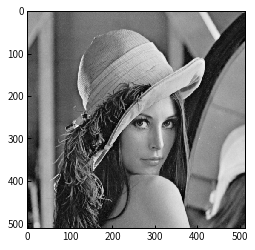

In [18]:
plt.imshow(R.T,cmap="gray")

In [19]:
DM4COMAT1, DM4COMAT2, DM4COMAT3, DM4COMAT4 = dm4coef(N)
print(
    DM4COMAT1, DM4COMAT2, DM4COMAT3, DM4COMAT4
)    

[[ 1.          1.          1.          1.          1.          1.
   1.          1.        ]
 [ 0.98078528  0.83146961  0.55557023  0.19509032 -0.19509032 -0.55557023
  -0.83146961 -0.98078528]
 [ 0.92387953  0.38268343 -0.38268343 -0.92387953 -0.92387953 -0.38268343
   0.38268343  0.92387953]
 [ 0.83146961 -0.19509032 -0.98078528 -0.55557023  0.55557023  0.98078528
   0.19509032 -0.83146961]
 [ 0.70710678 -0.70710678 -0.70710678  0.70710678  0.70710678 -0.70710678
  -0.70710678  0.70710678]
 [ 0.55557023 -0.98078528  0.19509032  0.83146961 -0.83146961 -0.19509032
   0.98078528 -0.55557023]
 [ 0.38268343 -0.92387953  0.92387953 -0.38268343 -0.38268343  0.92387953
  -0.92387953  0.38268343]
 [ 0.19509032 -0.55557023  0.83146961 -0.98078528  0.98078528 -0.83146961
   0.55557023 -0.19509032]]
[ 0.43590546 -0.03308095 -0.02931474 -0.03754339 -0.01782441 -0.01199148
 -0.00626287 -0.00307165] [ 1.20009613e+00 -3.69564240e-01 -2.07773481e-01 -4.54753960e-03
 -1.28180367e-02 -5.64949375e-04 -2